In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

In [2]:
from typing import List
from numpy.typing import NDArray

In [3]:
class Point():
    """General point class
    
    Attributes
    ----------
    centre : complex
        coords of point,
        random if no argument given

    Methods
    -------
    distance : float
        return distance to another point
    """

    def __init__(self, centre:complex=None) -> None:
        if centre:
            self.centre:complex = centre
        else:
            self.centre:complex = np.random.random() + 1j*np.random.random()

    def distance(self, other:'Point'):
        return abs(self.centre - other.centre)

In [4]:
class Particle(Point):
    """Sources to calculate multipoles from

    Inherits from Point class
    
    Attributes
    ----------
    centre : complex
        coords of point,
        random if no argument given
    charge : float
        charge associated with the point, real number,
        if no argument given, random in range [-1,1)

    Methods
    -------
    distance : float
        return distance to another point
    """

    def __init__(self, charge:float=None, centre:complex=None) -> None:
        super().__init__(centre)
        if charge:
            self.charge:float = charge
        else:
            # random in range -1 to 1
            self.charge:float = 2*np.random.random() - 1

In [5]:
class Cell(Point):
    """Class for cells that tree constructed from
    
    Inherits from Point
    
    Attributes
    ----------
    centre : complex
        coords of point,
        random if no argument given
    size : float
        size of the side of a box
    parent : Cell
        the parent cell


    n_particles : int
        number of particles in cell
    particles : list of Particle
        list of particles contained

    bit_children : bitwise
        child locations eg, child in 2 and 4 is 1010
    children : array of Cells
        cells children
    
    precision : int
        number of terms in multipole expansion
    multipole : NDArray of complex
        coefficients of the multipole expansion
    local : NDArray of complex
        coefficients of the multipole local

    Methods
    -------
    distance : float
        return distance to another point
    create_multipole : None
        generate multipole due to bodies contained
    """

    def __init__(self, centre:complex, size:float, precision:int=1, parent:'Cell'=None) -> None:
        super().__init__(centre)

        self.size:float = size

        self.parent:'Cell' = parent

        self.n_particles:int = 0
        self.particles:List[Particle] = []

        self.bit_children:int = 0 # 0000, bitwise operations
        self.children:NDArray[+object] = np.zeros(4, dtype=object)

        self.precision:int = precision
        self.multipole:NDArray[+complex] = np.zeros(precision, dtype=complex)
        self.local:NDArray[+complex] = np.zeros(precision, dtype=complex)

    def __repr__(self) -> str:
        return f'Cell: {self.centre} {self.n_particles} particle'
    
    def print_tree(self, level=0):
        print('\t'*level, f'({int(self.centre.real*2**(level) -0.5)},{int(self.centre.imag*2**(level) -0.5)})', self)
        for child in self.children:
            if child:
                child.print_tree(level+1)


    def _particle_quadrant(self, particle_centre:complex) -> int:
        """Return int 0 to 3 corresponding to the particles quadrant
        
        Will create child quadrant if not existing already
        """
        quadrant = (particle_centre.real > self.centre.real) | \
                    (particle_centre.imag > self.centre.imag)<<1 # int 0 to 3
        
        # check for no child child
        #   create if none
        # if there is no match between the bit children and the quadrant bit
        if not self.bit_children & (1 << quadrant):
            # bitwise operations to determine if left or right
            #   then if up or down, and apply appropriate shift
            # (if both yeild 0, then bottom left, otherwise relative to there) 
            child_centre =  self.centre + 0.25*self.size * (
                    (-1+2*(quadrant & 1)) + 1j*(-1+2*((quadrant & 2)>>1)))
            # add child to array of children, in correct location
            self.children[quadrant] = Cell(child_centre,
                                            self.size/2,
                                            self.precision,
                                            self)
            self.bit_children += (1<<quadrant)
            
        return quadrant
    

    def _split_cell(self, n_crit:int):
        """Splits self, distributing children and creating cells as needed"""

        for particle in self.particles:
            quadrant = self._particle_quadrant(particle.centre)
            # add particle to child
            self.children[quadrant].add_particle(particle,n_crit)

        
    def add_particle(self, particle:Particle, n_crit:int):
        self.n_particles += 1
        self.particles.append(particle)

        if self.n_particles < n_crit: # still leaf
            return
        
        elif self.n_particles == n_crit: # just become not leaf
            self._split_cell(n_crit)

        else: # already branch
            quadrant = self._particle_quadrant(particle.centre)
            # add particle to child
            self.children[quadrant].add_particle(particle,n_crit)


    def get_multipole(self):
        # get multipole coefficients
        charges = np.array([particle.charge for particle in self.particles])
        positions = np.array([particle.centre for particle in self.particles])
        # Q
        self.multipole[0] = np.sum(charges)
        # a_k
        for k in range(1, len(self.multipole)):
            self.multipole[k] = np.sum(-charges * (positions-self.centre)**k / k)

In [6]:
num_particles = 500
particles = [ Particle(1) for _ in range(num_particles) ]

root = Cell(0.5*(1+1j),1,4)

for particle in particles:
    root.add_particle(particle,n_crit=2)

# root.print_tree()

 (0,0) Cell: (0.5+0.5j) 500 particle
	 (0,0) Cell: (0.25+0.25j) 134 particle
		 (0,0) Cell: (0.125+0.125j) 26 particle
			 (0,0) Cell: (0.0625+0.0625j) 5 particle
				 (0,1) Cell: (0.03125+0.09375j) 4 particle
					 (0,2) Cell: (0.015625+0.078125j) 1 particle
					 (0,3) Cell: (0.015625+0.109375j) 1 particle
					 (1,3) Cell: (0.046875+0.109375j) 2 particle
						 (2,6) Cell: (0.0390625+0.1015625j) 1 particle
						 (2,7) Cell: (0.0390625+0.1171875j) 1 particle
				 (1,1) Cell: (0.09375+0.09375j) 1 particle
			 (1,0) Cell: (0.1875+0.0625j) 3 particle
				 (2,0) Cell: (0.15625+0.03125j) 1 particle
				 (3,0) Cell: (0.21875+0.03125j) 1 particle
				 (2,1) Cell: (0.15625+0.09375j) 1 particle
			 (0,1) Cell: (0.0625+0.1875j) 9 particle
				 (0,2) Cell: (0.03125+0.15625j) 3 particle
					 (0,4) Cell: (0.015625+0.140625j) 2 particle
						 (1,8) Cell: (0.0234375+0.1328125j) 2 particle
							 (2,16) Cell: (0.01953125+0.12890625j) 1 particle
							 (3,16) Cell: (0.02734375+0.12890625j) 1 par

In [7]:
root.get_multipole()
root.multipole

array([ 5.00000000e+02+0.j        ,  1.86472240e+00+2.01894722j,
       -2.65915433e-01-0.64083238j,  2.94771622e-01+0.8327668j ])

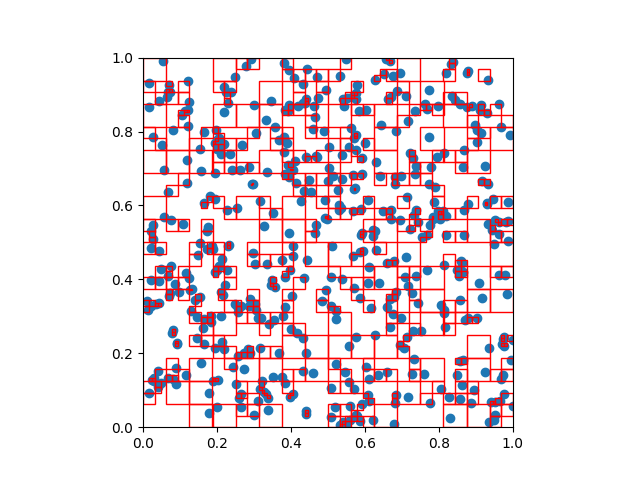

In [9]:
fig,ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlim(0,1)
ax.set_ylim(0,1)

points = [source.centre for source in particles]
X,Y = np.real(points), np.imag(points)

ax.scatter(X,Y)

import matplotlib.patches as patches

def draw_rectangles(cell:Cell):
    if cell.bit_children == 0:
        corner = cell.centre - cell.size*(0.5+0.5j)
        p = patches.Rectangle((corner.real,corner.imag),cell.size,cell.size, fill=False, color='red')
        ax.add_patch(p)
    else:
        for child in cell.children:
            if child:
                draw_rectangles(child)

draw_rectangles(root)

plt.show()

In [40]:
# particles = []
# particles.append(Particle(1, 0.25*(1+1j)))
# particles.append(Particle(2, 0.25*(3+1j)))
# particles.append(Particle(-2, 0.25*(1+3j)))
# particles.append(Particle(-3, 0.25*(3+3j)))